# 4 - Fine-tuning the top layers of a pre-trained network (VGG16)

### Imports

In [1]:
%matplotlib inline

import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras import optimizers
from keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
# Dimensions of our images.
img_width, img_height = 150, 150
n_classes = 25

train_data_dir = '../data/train'
validation_data_dir = '../data/validation'

### Data preprocessing

In [3]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size)

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size)

Found 40805 images belonging to 25 classes.
Found 8856 images belonging to 25 classes.


### Loading the VGG 16 model

It is direclty available in Keras.

In [4]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

We build a classifier model to put on top of the convolutional model. For the fine-tuning, we start with a fully trained classifier. We will use the weights from the earlier model. And then we will add this model on top of the convolutional base.

In [5]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

top_model.load_weights('../models/bottleneck.h5')

model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))

For fine-tuning, we only want to train a few layers. Therefore, we set the first 15 layers (up to the conv block) to non-trainable.

In [6]:
for layer in model.layers[:15]:
    layer.trainable = False

In [7]:
# Compile the model with a SGD/momentum optimizer and a slow learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

### Fine-tune the model

In [8]:
epochs = 100
train_samples = 40805
validation_samples = 8856

In [9]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='../models/finetuning_full.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    verbose=2,
    callbacks=[checkpointer, early_stopping],
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)

Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.83243, saving model to ../models/finetuning_full.h5
916s - loss: 1.0588 - acc: 0.7757 - val_loss: 0.9166 - val_acc: 0.8324
Epoch 2/100
Epoch 00001: val_acc did not improve
793s - loss: 0.4486 - acc: 0.9077 - val_loss: 0.8692 - val_acc: 0.7815
Epoch 3/100
Epoch 00002: val_acc improved from 0.83243 to 0.87443, saving model to ../models/finetuning_full.h5
794s - loss: 0.3174 - acc: 0.9349 - val_loss: 0.6207 - val_acc: 0.8744
Epoch 4/100
Epoch 00003: val_acc improved from 0.87443 to 0.88134, saving model to ../models/finetuning_full.h5
796s - loss: 0.2314 - acc: 0.9518 - val_loss: 0.6862 - val_acc: 0.8813
Epoch 5/100
Epoch 00004: val_acc improved from 0.88134 to 0.89198, saving model to ../models/finetuning_full.h5
794s - loss: 0.1973 - acc: 0.9600 - val_loss: 0.6974 - val_acc: 0.8920
Epoch 6/100
Epoch 00005: val_acc improved from 0.89198 to 0.90761, saving model to ../models/finetuning_full.h5
792s - loss: 0.1573 - acc: 0.9683 - val

### Evaluation on validation set

Computing loss and accuracy:

In [10]:
model.evaluate_generator(validation_generator, validation_samples / batch_size, workers=12)

[0.59153374412307613, 0.9397018970728136]

Learning curve:

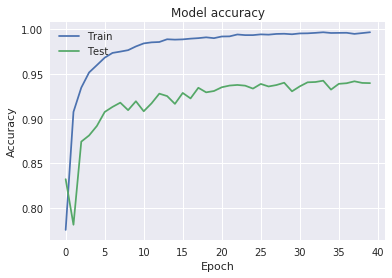

In [11]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('../images/finetuning_full.svg', format='svg', dpi=1200)

**We reached a 94% accuracy on the validation!**

### Saving the model as JSON

In [12]:
with open('../models/finetuning_full.json', 'w') as f:
    f.write(model.to_json())